In [1]:
import os, time, psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool, Lock

# Use a lock to prevent print statements from being scrambled
mp_lock = Lock()

data_dir = 'ml-1m'

movies_filename = 'movies.dat'
users_filename = 'users.dat'
ratings_filename = 'ratings.dat'

movie_columns = ['MovieID', 'Title', 'Genres']
user_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
rating_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']


def make_dataframe(data_dir, filename, columns):
    """
    Creates a dataframe from a data file
    
    data_dir: string, directory of data files
    filename: string, data filename
    columns: list, names for the columns of the dataframe
    
    """
    data_file = os.path.join(data_dir, filename)
    return pd.read_csv(data_file, delimiter='::', names=columns, encoding='latin-1', engine='python')


# Make the data frames for each data file
movies = make_dataframe(data_dir, movies_filename, movie_columns)
users = make_dataframe(data_dir, users_filename, user_columns)
ratings = make_dataframe(data_dir, ratings_filename, rating_columns)
data = (users, movies, ratings)

    
def rmse(errors):
    """
    Calculates the root mean squared error for an array of errors
    
    errors: array, array containing errors
    """
    return np.sqrt(np.mean(np.square(errors)))


def mae(errors):
    """
    Calculates the mean absolute error for an array of errors
    
    errors: array, array containing errors
    """
    return np.mean(np.abs(errors))


def crop_ratings(arr):
    """
    Ratings can only have values between 1.0 and 5.0. 
    This function sets all ratings > 5 to 5 and < 1 to 1.
    
    arr: array, array containing ratings
    """
    new_arr = np.where(arr > 5.0, 5.0, arr)
    new_arr = np.where(new_arr < 1.0, 1.0, arr)
    return new_arr


def rating_errors(data_set, model):
    """
    Calculates the rmse and mae of the errors between ratings from and data set
    and ratings predicted by a model.
    
    test_set: Dataframe, dataframe with the test data
    model: function, function that can act on the rows of a dataframe
    """
    errors = data_set['Rating'] - data_set.apply(model, axis=1)
    return rmse(errors), mae(errors)


def ids_to_indices(movie_ids):
    """
    We want for each movie ID the corresponding index of an array. For the users this 
    is straightforward, since the the user ID's are integers from 1 to the number of 
    users and we can just subtract 1 to get all the indices. For some reason, some integers 
    are skipped in the movie ID's, so we cannot use them directly as indices of an array. 
    
    For example: there is no movie with ID '91', so we want the movie with ID '92' 
    to correspond to an index of 90 (note that the first movie ID is '1' which 
    corresponds to index 0)
    
    Therefore we make an indices array with holes, which has parts like 
    [0, 1, ..., 218, 0, 219, 220, 221, ...]. The IDs '91' and '221' are missing. So a movie 
    with ID '222' will then take the 221st element of this array, which will take the value
    219 for the index, because 2 zeros are inserted for the missing IDs.
    
    movie_ids: array, array containing the ID's of all movies
    """
    ids_to_indices_arr = np.array([], dtype=np.int32)
    skipped_integers = 0
    for i in np.arange(len(movie_ids)):
        if movie_ids[i] == i + 1 + skipped_integers:
            ids_to_indices_arr = np.append(ids_to_indices_arr, i)
        else:
            while movie_ids[i] != i + 1 + skipped_integers:
                ids_to_indices_arr = np.append(ids_to_indices_arr, 0)
                skipped_integers += 1
            ids_to_indices_arr = np.append(ids_to_indices_arr, i)
    return ids_to_indices_arr


def make_movie_indices(data_set, movie_ids):
    """
    For a certain data set with movie ID's, return the corresponding indices of an array.
    
    data_set: Dataframe, dataframe containing ratings
    movie_ids: array, array containing the ID's of all movies
    """
    data_set_movie_ids = data_set['MovieID'].values - 1
    ids_to_indices_arr = ids_to_indices(movie_ids)
    movie_indices = ids_to_indices_arr[data_set_movie_ids]
    return movie_indices

In [2]:
def build_naive_model(mean_rating, train_set, model_type, model_specific_params):
    """
    Builds the naive model of a given type.
    
    mean_ratings: float, the mean of all ratings (in the train set)
    train_set: Dataframe, dataframe containing the training data
    model_type: string, type of the model (use '1', '2' or '3')
    model_specific_parmas: dict, dictionary containing objects specific to the model type
    """
    if model_type == '1':
        def model(row):
            return mean_rating
        return model
    elif model_type == '2':
        mean_rating_per_user = np.array([])
        
        for user_id in model_specific_params['user_ids']:
            user_subset = train_set[train_set['UserID'].values == user_id]
            mean_rating_per_user = np.append(mean_rating_per_user, np.mean(user_subset['Rating']))
        
        # replace the user mean rating by the global mean rating if it is not available
        mean_rating_per_user = np.where(np.isnan(mean_rating_per_user), mean_rating, mean_rating_per_user)

        def model(row):
            user_id = row['UserID'] - 1
            return mean_rating_per_user[user_id]
        return model
    elif model_type == '3':
        mean_rating_per_movie = np.array([])
        
        for movie_id in model_specific_params['movie_ids']:
            movie_subset = train_set[train_set['MovieID'].values == movie_id]
            mean_rating_per_movie = np.append(mean_rating_per_movie, np.mean(movie_subset['Rating']))
        
        # replace the movie mean rating by the global mean rating if it is not available
        mean_rating_per_movie = np.where(np.isnan(mean_rating_per_movie), mean_rating, mean_rating_per_movie)

        def model(row):
            movie_id = row['MovieID'] - 1
            return mean_rating_per_movie[model_specific_params['ids_to_indices_arr'][movie_id]]
        return model
    else:
        return ValueError(f'Model type {model_type} is unknown.')

    
def naive_model_fold_error(ratings, train_indices, test_indices, model_type, model_specific_params):
    """
    For a given fold, build the naive model and calculate its error on the test set.
    
    ratings: Dataframe, dataframe containing all ratings
    train_indices: array, indices of the training set
    test_indices array, indices of the test set
    model_type: string, type of the model (use '1', '2' or '3')
    model_specific_parmas: dict, dictionary containing objects specific to the model type
    """
    train_set = ratings.iloc[train_indices]
    test_set = ratings.iloc[test_indices]

    mean_rating = train_set['Rating'].mean()

    model = build_naive_model(mean_rating, train_set, model_type, model_specific_params)
    
    train_rmse, train_mae = rating_errors(train_set, model)
    test_rmse, test_mae = rating_errors(test_set, model)
    
    mp_lock.acquire()
    print('test rmse ', test_rmse, ' test mae ', test_mae)
    mp_lock.release()
    
    return train_rmse, test_rmse, train_mae, test_mae


def test_naive_model(data, model_type, n_folds=5):
    """
    Calculates the error for a given model. Bias in training and test set selection is reduced
    by using cross-validation. To speed up the process, we use multiprocessing to divide the 
    folds over different cores.
    
    data: tuple, contains the user, movie and rating dataframe
    model_type: string, type of the model (use '1', '2' or '3')
    n_folds: int, the number of folds to use for cross-validation
    """
    users, movies, ratings = data
    
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    print(f'Testing naive model {model_type}...')
    
    if model_type == '1':
        model_specific_params = {}
    elif model_type == '2':
        model_specific_params = {'user_ids': users['UserID']}
    elif model_type == '3':
        model_specific_params = {'movie_ids': movies['MovieID']}
        model_specific_params.update({'ids_to_indices_arr': 
                                      ids_to_indices(model_specific_params['movie_ids'])})
    else:
        return ValueError(f'Model type {model_type} is unknown.')
    
    params = [(ratings,
               train_indices, 
               test_indices, 
               model_type,
               model_specific_params) for train_indices, test_indices in cv.split(ratings)]
    pool = Pool(n_folds)
    fold_errors = pool.starmap(naive_model_fold_error, params)
    pool.close()
    pool.join()
    
    train_rmse_per_fold = np.array([])
    test_rmse_per_fold = np.array([])

    train_mae_per_fold = np.array([])
    test_mae_per_fold = np.array([])
    
    for errors in fold_errors:
        train_rmse, test_rmse, train_mae, test_mae = errors
        train_rmse_per_fold = np.append(train_rmse_per_fold, train_rmse)
        test_rmse_per_fold = np.append(test_rmse_per_fold, test_rmse)
        train_mae_per_fold = np.append(train_mae_per_fold, train_mae)
        test_mae_per_fold = np.append(test_mae_per_fold, test_mae)
    
    print('mean train rmse', np.mean(train_rmse_per_fold))
    print('mean test rmse', np.mean(test_rmse_per_fold))
    print('mean train mae', np.mean(train_mae_per_fold))
    print('mean test mae', np.mean(test_mae_per_fold))

In [3]:
t0 = time.time()

test_naive_model(data, model_type='1')

duration = time.time() - t0
print('Run time: ', duration, ' sec')

Testing naive model 1...
test rmse  1.1149881214282826  test mae  0.9326130200574327
test rmse  1.119729345062511  test mae  0.935986633921368
test rmse  1.1162190943284103  test mae  0.9328028300165171
test rmse  1.1180847521411108  test mae  0.9342782982805649
test rmse  1.1164859396819586  test mae  0.9336288110062256
mean train rmse 1.1171010587983956
mean test rmse 1.1171014505284547
mean train mae 0.9338605988479152
mean test mae 0.9338619186564217
Run time:  3.710469961166382  sec


In [4]:
t0 = time.time()

test_naive_model(data, model_type='2')

duration = time.time() - t0
print('Run time: ', duration, ' sec')

Testing naive model 2...
test rmse  1.035874276898819  test mae  0.828891912964882
test rmse  1.0394340299170062  test mae  0.8329949719978802
test rmse  1.0347421440592997  test mae  0.8280632808182781
test rmse  1.0331183095776237  test mae  0.8266677994054135
test rmse  1.034231441705486  test mae  0.8281312090560236
mean train rmse 1.0276727444564144
mean test rmse 1.0354800404316467
mean train mae 0.8227192335238153
mean test mae 0.8289498348484955
Run time:  13.072283744812012  sec


In [5]:
t0 = time.time()

test_naive_model(data, model_type='3')

duration = time.time() - t0
print('Run time: ', duration, ' sec')

Testing naive model 3...
test rmse  0.9797988738672946  test mae  0.781917272264237
test rmse  0.977362185832933  test mae  0.7799822708246255
test rmse  0.9771504870073922  test mae  0.7811692659016145
test rmse  0.9824065960588566  test mae  0.7851885462419244
test rmse  0.9801152379579418  test mae  0.783163630987873
mean train rmse 0.9742283446389879
mean test rmse 0.9793666761448836
mean train mae 0.7783363352007416
mean test mae 0.7822841972440548
Run time:  11.219701051712036  sec


In [6]:
# Overall mean rating 
mean_rating = ratings['Rating'].mean()

# Lookup tables for naive models 2, 3, 4 and 5
mean_rating_per_user = {user_id : ratings[ratings['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
mean_rating_per_movie = {movie_id : ratings[ratings['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}

def test_error_4_5(test_set,reg):
    
    mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in test_set['MovieID']])
    mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in test_set['UserID']])
    
    ##the predicted rating value for the test set using model 4 and 5.
    mean_rating_list = np.vstack((mean_rating_per_movie_list,mean_rating_per_user_list)).T
    pre_rating = reg.predict(mean_rating_list)[0]
    
    rating_error = ((test_set['Rating'] - pre_rating)**2).mean()**(1/2)
    
    return rating_error

In [7]:
def test_naive_model_4_5(data, subset:int=None):
    users, movies, ratings = data
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rating_errors_4 = np.array([])
    rating_errors_5 = np.array([])
    
    for train_index, test_index in cv.split(ratings):
        train_set = ratings.iloc[train_index]
        test_set = ratings.iloc[test_index]
        user_ids = train_set['UserID']
        
        mean_rating_per_movie = {movie_id : train_set[train_set['MovieID'] == movie_id]['Rating'].mean() for movie_id in movies['MovieID']}
        mean_rating_per_user = {user_id : train_set[train_set['UserID'] == user_id]['Rating'].mean() for user_id in users['UserID']}
        
        
        ##the lists of mean Ritem and mean Ruser for each rating in the train_set
        mean_rating_per_movie_list = np.array([mean_rating_per_movie[movie_id] for movie_id in train_set['MovieID']])
        mean_rating_per_user_list = np.array([mean_rating_per_user[user_id] for user_id in train_set['UserID']])
        
        ## stack the Ritem and Ruser lists for linear fitting
        mean_rating_list = np.vstack((mean_rating_per_movie_list, mean_rating_per_user_list)).T
        
        ## uisng Ordinary least squares Linear Regression to find alpha beta and gamma
        reg_4 = LinearRegression(fit_intercept=False).fit(mean_rating_list, train_set['Rating'])
        reg_5 = LinearRegression(fit_intercept=True).fit(mean_rating_list, train_set['Rating'])

        
        rating_err_4 = test_error_4_5(test_set,reg_4)
        rating_err_5 = test_error_4_5(test_set,reg_5)
        
        rating_errors_4 = np.append(rating_errors_4,rating_err_4)
        rating_errors_5 = np.append(rating_errors_5,rating_err_5)
        
        print('Rating Error for Naive Model 4:', rating_err_4)
        print('Rating Error for Naive Model 5:', rating_err_5)
    
    print('Mean Rating Error for Naive Model 4:', np.mean(rating_errors_4))   
    print('Mean Rating Error for Naive Model 5:', np.mean(rating_errors_5))

In [8]:
test_naive_model_4_5(data)

Rating Error for Naive Model 4: 1.355883535175115
Rating Error for Naive Model 5: 1.6272636448876663
Rating Error for Naive Model 4: 1.258558362688454
Rating Error for Naive Model 5: 1.455643650961396
Rating Error for Naive Model 4: 1.276126365946629
Rating Error for Naive Model 5: 1.4850790659505142
Rating Error for Naive Model 4: 1.131717217519981
Rating Error for Naive Model 5: 1.1786016924171567
Rating Error for Naive Model 4: 1.1960107991397175
Rating Error for Naive Model 5: 1.329055713915798
Mean Rating Error for Naive Model 4: 1.2436592560939794
Mean Rating Error for Naive Model 5: 1.4151287536265063


In [9]:
def mf_fold_error(ratings, train_indices, test_indices, users, movies, factors, n_training_steps, lr, lam):
    """
    For a given fold, train the UM matrix and keep track of the rating errors on the train and test set.
    
    ratings: Dataframe, dataframe containing the ratings
    train_indices: array, indices of the training set
    test_indices array, indices of the test set
    users: Dataframe, dataframe containing the users
    movies: Dataframe, dataframe containing the movies
    factors: int, the number of factors to use for the U and M matrix
    n_training_steps: int, the number of steps for training
    lr: float, learning rate 
    lam: float, lambda (used for regularization)
    """
    n_users = len(users)
    n_movies = len(movies)
    
    U = np.random.normal(0.0, 1.0, ((n_users, factors)))
    M = np.random.normal(0.0, 1.0, ((factors, n_movies)))
    
    train_set = ratings.iloc[train_indices]
    test_set = ratings.iloc[test_indices]

    train_user_indices = train_set['UserID'].values - 1
    test_user_indices = test_set['UserID'].values - 1

    movie_ids = movies['MovieID'].values
    train_movie_indices = make_movie_indices(train_set, movie_ids)
    test_movie_indices = make_movie_indices(test_set, movie_ids)
    
    train_set_rating_matrix = np.zeros((n_users, n_movies))
    for u, m, rating in zip(train_user_indices, train_movie_indices, train_set['Rating']):
        train_set_rating_matrix[u, m] = rating

    train_rmses = np.array([])
    test_rmses = np.array([])

    train_maes = np.array([])
    test_maes = np.array([])

    for step in range(n_training_steps):
        predicted_ratings = np.dot(U, M)

        train_set_predicted_ratings = predicted_ratings[train_user_indices, train_movie_indices]
        test_set_predicted_ratings = predicted_ratings[test_user_indices, test_movie_indices]

        train_errors = train_set['Rating'] - crop_ratings(train_set_predicted_ratings)
        test_errors = test_set['Rating'] - crop_ratings(test_set_predicted_ratings)
        
        train_rmse, test_rmse = rmse(train_errors), rmse(test_errors)
        
        train_rmses = np.append(train_rmses, train_rmse)
        test_rmses = np.append(test_rmses, test_rmse)

        train_maes = np.append(train_maes, mae(train_errors))
        test_maes = np.append(test_maes, mae(test_errors))

        mp_lock.acquire()
        print('step ', step, ' rmse train ', train_rmse, ' rmse test ', test_rmse)
        mp_lock.release()
        
        for u, m in zip(train_user_indices, train_movie_indices):
            u_vec, m_vec = U[u, :], M[:, m]
            error = train_set_rating_matrix[u, m] - np.dot(u_vec, m_vec)
            U[u, :] += lr * (2 * error * m_vec - lam * u_vec)
            M[:, m] += lr * (2 * error * U[u, :] - lam * m_vec)
    
    return train_rmses, test_rmses, train_maes, test_maes


def matrix_factorization(data, factors, n_training_steps, lr, lam, n_folds):
    """
    Calculates the error for the matrix factorization model. Bias in training and test set 
    selection is reduced by using cross-validation. To speed up the process, we use multiprocessing 
    to divide the folds over different cores.
    
    data: tuple, contains the user, movie and rating dataframe
    factors: int, the number of factors to use for the U and M matrix
    n_training_steps: int, the number of steps for training
    lr: float, learning rate 
    lam: float, lambda (used for regularization)
    n_folds: int, the number of folds to use for cross-validation
    """
    users, movies, ratings = data

    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)

    print('Testing matrix factorization model...')

    params = [(ratings,
               train_indices, 
               test_indices, 
               users, 
               movies, 
               factors, 
               n_training_steps, 
               lr, 
               lam) for train_indices, test_indices in cv.split(ratings)]
    pool = Pool(n_folds)
    fold_errors = pool.starmap(mf_fold_error, params)
    pool.close()
    pool.join()
    
    train_rmses_per_fold = np.array([])
    test_rmses_per_fold = np.array([])

    train_maes_per_fold = np.array([])
    test_maes_per_fold = np.array([])
    
    for errors in fold_errors:
        train_rmses, test_rmses, train_maes, test_maes = errors
        train_rmses_per_fold = np.append(train_rmses_per_fold, train_rmses)
        test_rmses_per_fold = np.append(test_rmses_per_fold, test_rmses)
        train_maes_per_fold = np.append(train_maes_per_fold, train_maes)
        test_maes_per_fold = np.append(test_maes_per_fold, test_maes)
    
    return np.stack((train_rmses_per_fold, 
                     test_rmses_per_fold, 
                     train_maes_per_fold, 
                     test_maes_per_fold))

number_of_folds = 5
number_of_training_steps = 75
number_of_factors = 10
learning_rate = 0.005
regularization = 0.05

np.random.seed(42)

t0 = time.time()

errors = matrix_factorization(data,
                              factors=number_of_factors,
                              n_training_steps=number_of_training_steps,
                              lr=learning_rate,
                              lam=regularization,
                              n_folds=number_of_folds)

duration = time.time() - t0

print('Run time: ', duration, ' sec')

Testing matrix factorization model...
step  0  rmse train  2.6014349134883816  rmse test  2.6108482677981546
step  0  rmse train  2.6034737677922672  rmse test  2.602706385409006
step  0  rmse train  2.604653921123481  rmse test  2.597979022703702
step  0  rmse train  2.603880273225993  rmse test  2.6010792506915794
step  0  rmse train  2.603157576718127  rmse test  2.603971140974104
step  1  rmse train  1.5012680199728958  rmse test  1.534151677834486
step  1  rmse train  1.490806497728355  rmse test  1.5275541256802776
step  1  rmse train  1.5101981483222924  rmse test  1.5464018564118935
step  1  rmse train  1.4934905479371927  rmse test  1.5334731026744834
step  1  rmse train  1.5033886957015101  rmse test  1.53502091138808
step  2  rmse train  0.9876743967178091  rmse test  1.042040875246315
step  2  rmse train  0.9846294981070677  rmse test  1.0471146012033656
step  2  rmse train  0.9857446607027487  rmse test  1.0456966656584832
step  2  rmse train  0.9896938375219059  rmse test

step  22  rmse train  0.8355954094111641  rmse test  0.9154030669379927
step  23  rmse train  0.8325168566900778  rmse test  0.912393592754138
step  23  rmse train  0.8327474070505134  rmse test  0.9127044139521816
step  23  rmse train  0.8327228355248704  rmse test  0.917943942356999
step  23  rmse train  0.8324223196613634  rmse test  0.9108287411773878
step  23  rmse train  0.8330094992265126  rmse test  0.9138671363741249
step  24  rmse train  0.8300221707337536  rmse test  0.9109500533830788
step  24  rmse train  0.8302435884699132  rmse test  0.9113147756711542
step  24  rmse train  0.8299404141522921  rmse test  0.9094035241188145
step  24  rmse train  0.8303327641652104  rmse test  0.9164921616682399
step  24  rmse train  0.8305365879107625  rmse test  0.9124126506281484
step  25  rmse train  0.8276425439448859  rmse test  0.9095876403327731
step  25  rmse train  0.8278582095802374  rmse test  0.910000059165378
step  25  rmse train  0.8280526341953256  rmse test  0.915116586310

step  45  rmse train  0.7970672387822092  rmse test  0.8918730722923254
step  45  rmse train  0.797474120793486  rmse test  0.8945567253317781
step  46  rmse train  0.7962017037571956  rmse test  0.8927844053426663
step  46  rmse train  0.796967955242233  rmse test  0.8937608487082237
step  46  rmse train  0.7975098370367227  rmse test  0.8977619580360319
step  46  rmse train  0.7961142634132302  rmse test  0.8914083539818868
step  46  rmse train  0.7965202572489513  rmse test  0.8940987376521311
step  47  rmse train  0.7952865105671972  rmse test  0.8923154169329278
step  47  rmse train  0.7960937521843375  rmse test  0.8933271020062161
step  47  rmse train  0.7965992312884598  rmse test  0.8972641767440732
step  47  rmse train  0.7951977428954843  rmse test  0.8909623901595342
step  47  rmse train  0.7956038521700773  rmse test  0.8936620604883856
step  48  rmse train  0.7944060714617949  rmse test  0.8918648018960458
step  48  rmse train  0.7952538879244454  rmse test  0.89291306404

step  68  rmse train  0.7832205514525419  rmse test  0.8897811997555324
step  68  rmse train  0.7821187859939728  rmse test  0.8848014468719387
step  68  rmse train  0.7824767870867165  rmse test  0.8875700920315632
step  69  rmse train  0.7818040461399502  rmse test  0.8853881181384906
step  69  rmse train  0.7832473442643687  rmse test  0.8873211368500226
step  69  rmse train  0.7827859188057256  rmse test  0.8895321575763997
step  69  rmse train  0.7817072722270665  rmse test  0.8846137186757783
step  69  rmse train  0.7820551625860693  rmse test  0.8873746614503563
step  70  rmse train  0.7814063120342163  rmse test  0.885180633575273
step  70  rmse train  0.7823649118795997  rmse test  0.8892902412630449
step  70  rmse train  0.7828635622981213  rmse test  0.8871578698152691
step  70  rmse train  0.7813092344357805  rmse test  0.8844322804427426
step  70  rmse train  0.7816463385005938  rmse test  0.8871841879871267
step  71  rmse train  0.781021476092387  rmse test  0.88497938671

Final train rmse:  0.7804319447057322
Final test rmse:  0.8859206597041049
Final train mae:  0.6144913398872665
Final test mae:  0.6922530922628514


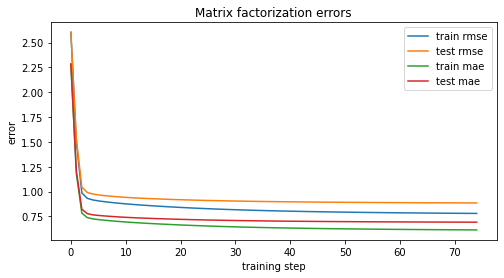

In [10]:
mean_train_rmses = np.mean(np.reshape(errors[0], (number_of_folds, number_of_training_steps)), axis=0)
mean_test_rmses = np.mean(np.reshape(errors[1], (number_of_folds, number_of_training_steps)), axis=0)
mean_train_maes = np.mean(np.reshape(errors[2], (number_of_folds, number_of_training_steps)), axis=0)
mean_test_maes = np.mean(np.reshape(errors[3], (number_of_folds, number_of_training_steps)), axis=0)

print('Final train rmse: ', mean_train_rmses[-1])
print('Final test rmse: ', mean_test_rmses[-1])
print('Final train mae: ', mean_train_maes[-1])
print('Final test mae: ', mean_test_maes[-1])

training_steps = np.arange(number_of_training_steps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(training_steps, mean_train_rmses, label='train rmse', rasterized=True)
ax.plot(training_steps, mean_test_rmses, label='test rmse', rasterized=True)
ax.plot(training_steps, mean_train_maes, label='train mae', rasterized=True)
ax.plot(training_steps, mean_test_maes, label='test mae', rasterized=True)
ax.set_title('Matrix factorization errors')
ax.set_xlabel('training step')
ax.set_ylabel('error')
ax.legend()
plt.savefig('mf_errors.pdf')
plt.show()